### Make dataset - 동양인 데이터셋 load

In [48]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = r'C:\Users\MyLaptop\Desktop\40, 320 + cascade-20201112T044808Z-001\40, 320 + cascade'
print(len(os.listdir(data_dir)))

IMAGE_SIZE = (160, 160) # 이전에 학습된 모델을 불러오기 때문에 input_shape을 맞춰준다
BATCH_SIZE = 64 # 노트북 memory에 맞춰서 조절

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
    )

print(train_ds)
print(val_ds)

320
Found 12287 files belonging to 320 classes.
Using 9830 files for training.
Found 12287 files belonging to 320 classes.
Using 2457 files for validation.
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


In [49]:
from tensorflow.keras import layers

# 이미지가 0~1 사이의 값을 가지도록 정규화
def normalization_dataset(dataset):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))
    return normalized_ds 

train_ds = normalization_dataset(train_ds)
val_ds = normalization_dataset(val_ds)
print(train_ds)
print(val_ds)

<MapDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


In [50]:
# cache() 첫 번째 에포크 동안 디스크에서로드 된 이미지를 메모리에 보관합니다. 
# prefetch 학습 중에 데이터 전처리 및 모델 실행과 겹칩니다

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### import Module

In [51]:
import numpy as np

# import tensorflow_hub as hub
import tensorflow_addons as tfa
 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models

### 서양인에 맞춰서 학습된 facenet.h5 model load

In [52]:
model = models.load_model(r'C:\Users\MyLaptop\Documents\Jupyter notebook\RF_access_system\model\facenet.h5')

In [53]:
# model layer 확인
# model.summary()
model.layers[-2:]

In [54]:
# 동양인 데이터에 맞춰서 재학습 시키기 위해 마지막 dense layer를 가지고 와서 학습 가능으로 변경

for layer in model.layers[-2:]:
    layer.trainable = True

# 마지막 2개의 layer에 접근하며 커널이 존재할 경우 가중치의 shape을 저장
# 초기 가중치의 값을 0~1의 값으로 설정
    
for layer in model.layers[-2:]:
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))

### Model train

In [25]:
# compile setting
# optimizer : SGD(lr = 0.05) 논문에서의 세팅값
# loss : tripletSemiHardLoss 논문에서의 세팅값 

SGD = SGD(lr=0.05)
model.compile(optimizer=SGD, loss=tfa.losses.TripletSemiHardLoss())

history = model.fit(train_ds ,validation_data=val_ds, epochs=1000,
                   callbacks = [tf.keras.callbacks.EarlyStopping(patience = 50, monitor = 'val_loss')])

Epoch 1/1000
154/154 [==============================] - 64s 413ms/step - loss: 0.3854 - val_loss: 0.6568
Epoch 2/1000
154/154 [==============================] - 63s 410ms/step - loss: 0.1977 - val_loss: 0.3708
Epoch 3/1000
154/154 [==============================] - 63s 407ms/step - loss: 0.0795 - val_loss: 0.3006
Epoch 4/1000
154/154 [==============================] - 62s 406ms/step - loss: 0.0321 - val_loss: 0.3181
Epoch 5/1000
154/154 [==============================] - 62s 406ms/step - loss: 0.0145 - val_loss: 0.2642
Epoch 6/1000
154/154 [==============================] - 63s 406ms/step - loss: 0.0085 - val_loss: 0.2410
Epoch 7/1000
154/154 [==============================] - 62s 405ms/step - loss: 0.0039 - val_loss: 0.2547
Epoch 8/1000
154/154 [==============================] - 62s 405ms/step - loss: 0.0038 - val_loss: 0.2395
Epoch 9/1000
154/154 [==============================] - 62s 403ms/step - loss: 0.0033 - val_loss: 0.2451
Epoch 10/1000
154/154 [==============================] 

### loss graph 확인

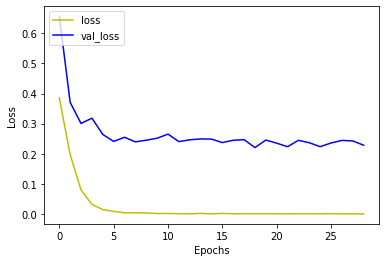

In [31]:
# loss 그래프

import matplotlib.pyplot as plt
plt.figure("val_graph")
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'],'b', label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

### Model save

In [41]:
SGD = SGD(lr=0.05)
model.compile(optimizer=SGD, loss=tfa.losses.TripletSemiHardLoss())

history = model.fit(train_ds ,validation_data=val_ds, epochs=1000,
                   callbacks = [tf.keras.callbacks.EarlyStopping(patience = 50, monitor = 'val_loss')])

Epoch 1/1000
154/154 [==============================] - 60s 391ms/step - loss: 0.3849 - val_loss: 0.5148
Epoch 2/1000
154/154 [==============================] - 60s 389ms/step - loss: 0.1783 - val_loss: 0.3646
Epoch 3/1000
154/154 [==============================] - 61s 399ms/step - loss: 0.0794 - val_loss: 0.3238
Epoch 4/1000
154/154 [==============================] - 62s 400ms/step - loss: 0.0317 - val_loss: 0.3063
Epoch 5/1000
154/154 [==============================] - 62s 401ms/step - loss: 0.0172 - val_loss: 0.2646
Epoch 6/1000
154/154 [==============================] - 61s 397ms/step - loss: 0.0090 - val_loss: 0.2608
Epoch 7/1000
154/154 [==============================] - 62s 401ms/step - loss: 0.0066 - val_loss: 0.2918
Epoch 8/1000
154/154 [==============================] - 62s 403ms/step - loss: 0.0043 - val_loss: 0.2394
Epoch 9/1000
154/154 [==============================] - 63s 412ms/step - loss: 0.0042 - val_loss: 0.2529
Epoch 10/1000
154/154 [==============================] 

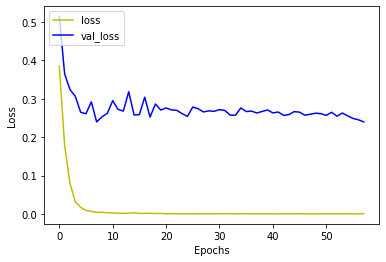

In [42]:
# loss 그래프

import matplotlib.pyplot as plt
plt.figure("val_graph")
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'],'b', label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [43]:
model.save(r'C:\Users\MyLaptop\Documents\Jupyter notebook\RF_access_system\model\facenet2.h5')

In [ ]:
SGD = SGD(lr=0.05)
model.compile(optimizer=SGD, loss=tfa.losses.TripletSemiHardLoss())

history = model.fit(train_ds ,validation_data=val_ds, epochs=1000)

Epoch 1/1000
154/154 [==============================] - 61s 396ms/step - loss: 0.3936 - val_loss: 0.6719
Epoch 2/1000
154/154 [==============================] - 59s 385ms/step - loss: 0.1857 - val_loss: 0.3900
Epoch 3/1000
154/154 [==============================] - 60s 389ms/step - loss: 0.0652 - val_loss: 0.3595
Epoch 4/1000
154/154 [==============================] - 60s 391ms/step - loss: 0.0266 - val_loss: 0.2728
Epoch 5/1000
154/154 [==============================] - 60s 393ms/step - loss: 0.0155 - val_loss: 0.2800
Epoch 6/1000
154/154 [==============================] - 61s 394ms/step - loss: 0.0066 - val_loss: 0.2411
Epoch 7/1000
154/154 [==============================] - 61s 394ms/step - loss: 0.0072 - val_loss: 0.2442
Epoch 8/1000
154/154 [==============================] - 61s 394ms/step - loss: 0.0041 - val_loss: 0.2691
Epoch 9/1000
154/154 [==============================] - 61s 395ms/step - loss: 0.0055 - val_loss: 0.2603
Epoch 10/1000
154/154 [==============================] 

154/154 [==============================] - 61s 396ms/step - loss: 0.0000e+00 - val_loss: 0.2055
Epoch 75/1000
154/154 [==============================] - 61s 396ms/step - loss: 5.0040e-05 - val_loss: 0.2068
Epoch 76/1000
154/154 [==============================] - 61s 395ms/step - loss: 5.3714e-04 - val_loss: 0.1968
Epoch 77/1000
154/154 [==============================] - 61s 394ms/step - loss: 0.0000e+00 - val_loss: 0.1951
Epoch 78/1000
154/154 [==============================] - 61s 393ms/step - loss: 0.0000e+00 - val_loss: 0.1952
Epoch 79/1000
154/154 [==============================] - 61s 394ms/step - loss: 0.0000e+00 - val_loss: 0.1999
Epoch 80/1000
154/154 [==============================] - 61s 394ms/step - loss: 2.1183e-04 - val_loss: 0.1935
Epoch 81/1000
154/154 [==============================] - 61s 393ms/step - loss: 0.0000e+00 - val_loss: 0.1942
Epoch 82/1000
154/154 [==============================] - 61s 393ms/step - loss: 0.0000e+00 - val_loss: 0.1955
Epoch 83/1000
154/154 [=

154/154 [==============================] - 60s 388ms/step - loss: 0.0000e+00 - val_loss: 0.2218
Epoch 149/1000
154/154 [==============================] - 60s 388ms/step - loss: 2.3267e-05 - val_loss: 0.2150
Epoch 150/1000
154/154 [==============================] - 60s 389ms/step - loss: 0.0000e+00 - val_loss: 0.2108
Epoch 151/1000
154/154 [==============================] - 59s 386ms/step - loss: 0.0000e+00 - val_loss: 0.2128
Epoch 152/1000
154/154 [==============================] - 60s 387ms/step - loss: 2.5928e-05 - val_loss: 0.2177
Epoch 153/1000
154/154 [==============================] - 60s 388ms/step - loss: 0.0000e+00 - val_loss: 0.2163
Epoch 154/1000
154/154 [==============================] - 61s 394ms/step - loss: 2.4000e-04 - val_loss: 0.2151
Epoch 155/1000
154/154 [==============================] - 60s 393ms/step - loss: 5.8608e-06 - val_loss: 0.2065
Epoch 156/1000
154/154 [==============================] - 60s 391ms/step - loss: 0.0000e+00 - val_loss: 0.2141
Epoch 157/1000
1